## Toy task evaluation

This notebook contains a proof-of-concept evaluation on a small toy task. 

In [1]:
from src.model import Transformer, TransformerConfig
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Expectation: should be able to predict the next word with 100% accuracy, except for the last word, where it should be undecided between "working" and "broken"
sentences = ["this transformer is working", "this transformer is broken"]
words = {"this": 0, "transformer": 1, "is": 2, "working": 3, "broken": 4, "<end>": 5}
max_input_length = 4
training_data = torch.LongTensor([[words[word] for word in example.split(" ")] for example in sentences])
y = torch.LongTensor([[words[word] for word in example.split(" ")[1:]] + [words["<end>"]] for example in sentences]).view(-1)

In [3]:
one_hot_y = nn.functional.one_hot(y, num_classes=len(words)).float()
transformer = Transformer(TransformerConfig(vocab_size=len(words), max_input_length=max_input_length, num_heads=2, num_blocks=2, embedding_size=16))
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(transformer.parameters(), lr=5e-5)

for i in range(10000):
    x = transformer(training_data)
    x = x.view(-1, x.shape[-1])
    loss = loss_fn(x, one_hot_y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if (i+1)%1000 == 0:
        print(f"Step: {i}, loss: {loss}")
        print(np.round(x.detach().numpy()[:max_input_length], 3))

Step: 999, loss: 0.12502583861351013
[[0.724 0.199 0.063 0.002 0.003 0.009]
 [0.001 0.127 0.773 0.014 0.    0.085]
 [0.001 0.    0.264 0.001 0.    0.735]
 [0.    0.    0.026 0.034 0.    0.939]]
Step: 1999, loss: 0.06449530273675919
[[0.001 0.997 0.001 0.001 0.    0.   ]
 [0.    0.015 0.975 0.003 0.    0.007]
 [0.    0.    0.348 0.001 0.    0.651]
 [0.    0.    0.001 0.02  0.    0.978]]
Step: 2999, loss: 0.06359555572271347
[[0.    0.995 0.002 0.002 0.    0.   ]
 [0.    0.002 0.903 0.001 0.    0.093]
 [0.    0.    0.588 0.002 0.    0.41 ]
 [0.    0.    0.008 0.003 0.    0.988]]
Step: 3999, loss: 0.047177862375974655
[[0.001 0.994 0.002 0.003 0.    0.   ]
 [0.    0.001 0.951 0.023 0.    0.025]
 [0.    0.    0.489 0.316 0.002 0.193]
 [0.    0.    0.006 0.009 0.    0.985]]
Step: 4999, loss: 0.03269888833165169
[[0.003 0.995 0.001 0.001 0.    0.001]
 [0.    0.001 0.979 0.01  0.001 0.009]
 [0.    0.    0.091 0.783 0.001 0.125]
 [0.    0.    0.001 0.    0.    0.999]]
Step: 5999, loss: 0.03429

[[0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.998 0.    0.    0.001]
 [0.    0.    0.017 0.461 0.506 0.016]
 [0.    0.    0.001 0.    0.    0.999]]


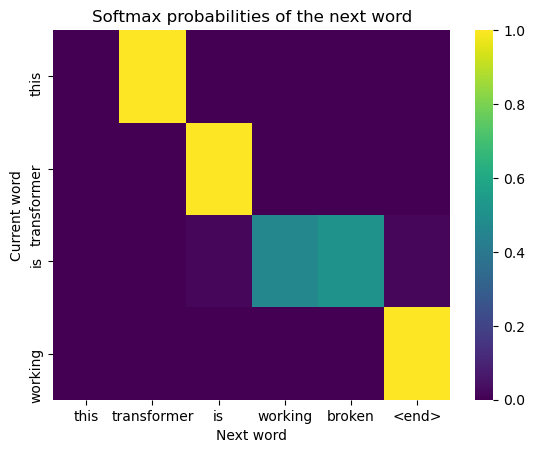

In [5]:
transformer.eval()

with torch.no_grad():
    test_input = "this transformer is working".split(" ")
    test_data = torch.LongTensor([[words[word] for word in test_input]])
    x = transformer(test_data).detach()
    x = np.round(x.view(-1, x.shape[-1]).numpy(), 3)

print(x)

g = sns.heatmap(x, cmap="viridis")
g.set_ylabel("Current word")
g.set_xlabel("Next word")
g.set_title("Softmax probabilities of the next word")
g.set_xticks([i+0.5 for i in range(6)], ["this", "transformer", "is", "working", "broken", "<end>"])
g.set_yticks([i+0.5 for i in range(4)], test_input)
plt.show()